In [1]:
import gzip
import joblib
import pandas
import pickle
import seaborn
import tqdm

from lib.models.generic_v0.model import map_params

In [2]:
import sys

util_dir = "./sprint-0-explicit-mdps/"
sys.path.append(util_dir)

import util

In [3]:
fixed_dag_size = pandas.read_pickle(
    "5-generated-mdps/fixed.pkl.gz"
).dag_size_limit.drop_duplicates()
assert len(fixed_dag_size) == 1
fixed_dag_size = fixed_dag_size.iloc[0]
fixed_dag_size

6

In [4]:
mdps = pandas.read_pickle("5-generated-mdps/success.pkl.gz")
mdps

max_dag_size = mdps.query(
    'problem == "v1+fc+n" and protocol == "bitcoin"'
).dag_size_limit.max()
max_dag_size

biggest_v1 = mdps.query(
    f'problem == "v1+fc+n" and protocol == "bitcoin" and dag_size_limit <= {max_dag_size}'
)
biggest_v1


ref_models = mdps.query(
    f'problem.str.startswith("ref") and dag_size_limit <= {max_dag_size}'
)
ref_models

mdps = pandas.concat([biggest_v1, ref_models])

In [5]:
networks = []
# for alpha in range(5, 46, 5):
for alpha in [33]:
    for gamma in [0.33, 0.66]:
        # for gamma in [0, 0.5, 1]:
        networks.append(dict(alpha=alpha / 100, gamma=gamma))
# pandas.DataFrame(networks)

In [6]:
horizon = 100
stop_delta = (
    0.0001  # value iteration stops when no value estimate changes more than this value
)

In [7]:
def optimize(network, idx, row):
    with gzip.open(f"5-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
        emdp = pickle.load(f)
        emdp = map_params(emdp, **network)
        oae = util.optimize_and_evaluate(emdp, eps=stop_delta, horizon=horizon)
        return row.to_dict() | dict(horizon=horizon) | network | oae


def generate_jobs():
    for network in networks:
        for idx, row in mdps.iterrows():
            # if row['size'] > 1000:
            #    continue
            yield joblib.delayed(optimize)(network, idx, row)


jobs = list(generate_jobs())
generate_solutions = joblib.Parallel(return_as="generator_unordered", n_jobs=6)(jobs)
with_progress = tqdm.tqdm(generate_solutions, total=len(jobs))
df = pandas.DataFrame(with_progress)
df.to_pickle("6-value-iterations.pkl.gz")
df

  0%|                                                                                                                                                                  | 0/60 [00:00<?, ?it/s]

  2%|██▌                                                                                                                                                       | 1/60 [00:00<00:28,  2.06it/s]

  3%|█████▏                                                                                                                                                    | 2/60 [00:00<00:18,  3.07it/s]

  7%|██████████▎                                                                                                                                               | 4/60 [00:01<00:21,  2.63it/s]

  8%|████████████▊                                                                                                                                             | 5/60 [00:03<00:46,  1.18it/s]

 12%|█████████████████▉                                                                                                                                        | 7/60 [00:03<00:25,  2.06it/s]

 13%|████████████████████▌                                                                                                                                     | 8/60 [00:04<00:28,  1.79it/s]

 17%|█████████████████████████▌                                                                                                                               | 10/60 [00:04<00:17,  2.82it/s]

 18%|████████████████████████████                                                                                                                             | 11/60 [00:05<00:19,  2.45it/s]

 22%|█████████████████████████████████▏                                                                                                                       | 13/60 [00:05<00:14,  3.29it/s]

 23%|███████████████████████████████████▋                                                                                                                     | 14/60 [00:05<00:14,  3.11it/s]

 25%|██████████████████████████████████████▎                                                                                                                  | 15/60 [00:06<00:17,  2.63it/s]

 27%|████████████████████████████████████████▊                                                                                                                | 16/60 [00:07<00:24,  1.83it/s]

 28%|███████████████████████████████████████████▎                                                                                                             | 17/60 [00:08<00:25,  1.70it/s]

 30%|█████████████████████████████████████████████▉                                                                                                           | 18/60 [00:08<00:24,  1.69it/s]

 33%|███████████████████████████████████████████████████                                                                                                      | 20/60 [00:08<00:15,  2.60it/s]

 35%|█████████████████████████████████████████████████████▌                                                                                                   | 21/60 [00:09<00:14,  2.74it/s]

 37%|████████████████████████████████████████████████████████                                                                                                 | 22/60 [00:09<00:14,  2.61it/s]

 40%|█████████████████████████████████████████████████████████████▏                                                                                           | 24/60 [00:10<00:13,  2.61it/s]

 42%|███████████████████████████████████████████████████████████████▊                                                                                         | 25/60 [00:10<00:12,  2.89it/s]

 45%|████████████████████████████████████████████████████████████████████▊                                                                                    | 27/60 [00:11<00:09,  3.37it/s]

 47%|███████████████████████████████████████████████████████████████████████▍                                                                                 | 28/60 [00:11<00:12,  2.61it/s]

 48%|█████████████████████████████████████████████████████████████████████████▉                                                                               | 29/60 [00:20<01:17,  2.49s/it]

 50%|████████████████████████████████████████████████████████████████████████████▌                                                                            | 30/60 [00:34<02:36,  5.20s/it]

 52%|███████████████████████████████████████████████████████████████████████████████                                                                          | 31/60 [00:34<01:51,  3.85s/it]

 53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                       | 32/60 [00:35<01:29,  3.20s/it]

 55%|████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 33/60 [00:39<01:27,  3.25s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 34/60 [00:47<02:02,  4.72s/it]

 58%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 35/60 [01:00<02:59,  7.17s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 37/60 [01:00<01:30,  3.95s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 38/60 [01:01<01:10,  3.22s/it]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 40/60 [01:01<00:38,  1.93s/it]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 41/60 [01:02<00:31,  1.64s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 43/60 [01:02<00:17,  1.06s/it]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 44/60 [01:03<00:14,  1.08it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 45/60 [01:04<00:13,  1.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 46/60 [01:05<00:13,  1.04it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 47/60 [01:06<00:14,  1.11s/it]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 48/60 [01:08<00:15,  1.31s/it]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 50/60 [01:08<00:07,  1.26it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 51/60 [01:09<00:06,  1.47it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 52/60 [01:09<00:04,  1.60it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 53/60 [01:10<00:04,  1.46it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 54/60 [01:11<00:04,  1.26it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 55/60 [01:12<00:04,  1.05it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 56/60 [01:51<00:47, 11.90s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 57/60 [02:44<01:11, 23.81s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 58/60 [03:12<00:50, 25.04s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 59/60 [06:38<01:18, 78.62s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [07:41<00:00, 73.79s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [07:41<00:00,  7.69s/it]

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,...,vi_time,vi_max_value,ss_reachable,ss_nonzero,ss_time,pe_iter,ptrev,rpp,time,vi_steady_value
0,v1+fc+n,generic-v1,True,True,True,True,True,bitcoin,2,5,...,0.045963,33.323488,4,4,0.053443,2,0.163350,0.330000,0.099694,32.660188
1,v1+fc+n,generic-v1,True,True,True,True,True,bitcoin,3,18,...,0.122142,33.970353,6,4,0.054927,2,0.163350,0.330000,0.177663,32.660188
2,v1+fc+n,generic-v1,True,True,True,True,True,bitcoin,4,45,...,0.296921,34.600949,6,4,0.055972,2,0.163350,0.330000,0.354052,32.660188
3,v1+fc+n,generic-v1,True,True,True,True,True,bitcoin,5,120,...,1.003174,35.683087,19,19,0.001295,2,0.132453,0.337361,1.006798,33.430280
4,v1+fc+n,generic-v1,True,True,True,True,True,bitcoin,6,300,...,2.678546,36.938736,34,34,0.001440,2,0.132842,0.345092,2.685948,34.208639
5,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,2,3,...,0.019039,33.323488,3,3,0.000905,2,0.326700,0.330000,0.020106,32.660188
6,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,4,18,...,0.126539,35.364783,9,9,0.001067,2,0.267259,0.336973,0.128176,33.394970
7,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,8,90,...,0.764344,40.772717,37,37,0.001432,2,0.269924,0.355041,0.768460,35.265194
8,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,2,3,...,0.025802,33.323488,3,3,0.000939,2,0.163350,0.330000,0.026873,32.660139
9,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,4,15,...,0.109332,35.355691,10,10,0.001057,2,0.153256,0.336973,0.110738,33.306105


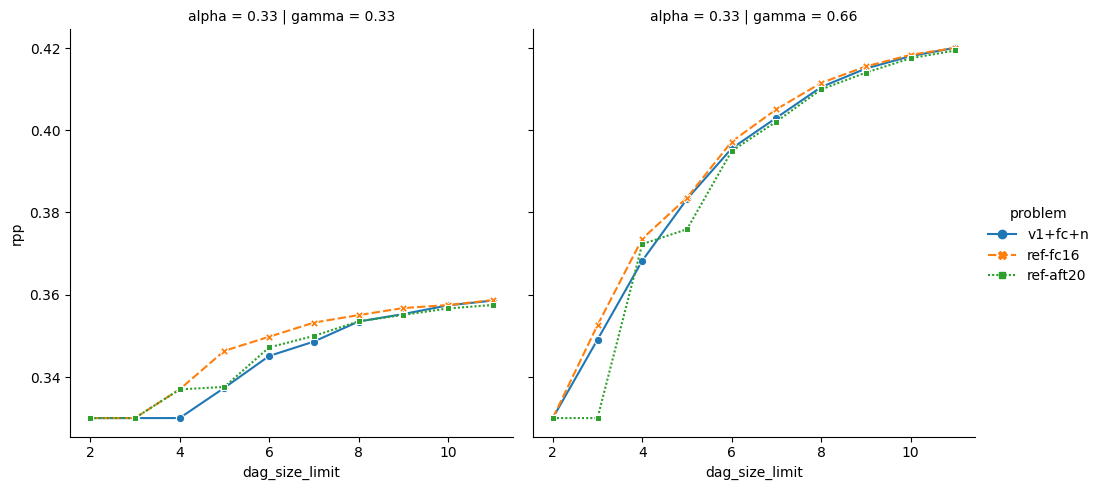

In [8]:
seaborn.relplot(
    data=df,
    kind="line",
    x="dag_size_limit",
    y="rpp",
    hue="problem",
    style="problem",
    markers=True,
    col="gamma",
    row="alpha",
)

In [9]:
!rm -f 6-bitcoin-rpp-for-dag-size-alpha*-gamma*.csv

In [10]:
for alpha in df.alpha.drop_duplicates():
    for gamma in df.gamma.drop_duplicates():
        fname = f"6-bitcoin-rpp-for-dag-size-alpha{str(alpha)[2:]}-gamma{str(gamma)[2:]}.csv"
        sdf = df.query(f"alpha == {alpha} and gamma == {gamma}")[
            ["problem", "dag_size_limit", "rpp"]
        ]
        sdf = sdf.pivot(index="dag_size_limit", columns="problem", values="rpp")
        sdf.to_csv(fname)
sdf

problem,ref-aft20,ref-fc16,v1+fc+n
dag_size_limit,,,
2,0.330000,0.330000,0.330000
3,0.330000,0.352596,0.349084
4,0.372304,0.373609,0.368257
5,0.375918,0.383576,0.383257
6,0.394942,0.397233,0.395573
7,0.402120,0.405106,0.403036
8,0.409916,0.411505,0.410498
9,0.414010,0.415510,0.414997
10,0.417501,0.418339,0.418019


In [11]:
!ls 6-bitcoin-rpp-for-dag-size-alpha*-gamma*.csv

6-bitcoin-rpp-for-dag-size-alpha33-gamma33.csv
6-bitcoin-rpp-for-dag-size-alpha33-gamma66.csv
